# Ordinary Least Squares on magnet challenge dataset

In [1]:
import matplotlib.pyplot as plt
import xgboost
import matplotlib
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy.interpolate import UnivariateSpline
from scipy.integrate import trapezoid

from utils.experiments import get_stratified_fold_indices, PROC_SOURCE, form_factor, crest_factor

In [19]:
filepath = 'D:\Dokumente\Studium\SHK2\projects\magnet_challenge\magnet-challenge-2023\data\input\processed'
material_name = 'ten_materials'
ds = pd.read_pickle(f'{filepath}/{material_name}.pkl.gz')

ds = ds.drop(columns=[c for c in ds if c.startswith("H_t")])

#ds = ds.query('temp == 25')

# add the saturation flux density. Data from datasheets.
ds.loc[ds['material'] == '3C90', 'b_sat_25'] = 0.47
ds.loc[ds['material'] == '3C94', 'b_sat_25'] = 0.47
ds.loc[ds['material'] == '3E6', 'b_sat_25'] = 0.46
ds.loc[ds['material'] == '3F4', 'b_sat_25'] = 0.41
ds.loc[ds['material'] == '77', 'b_sat_25'] = 0.51
ds.loc[ds['material'] == '78', 'b_sat_25'] = 0.48
ds.loc[ds['material'] == 'N27', 'b_sat_25'] = 0.50
ds.loc[ds['material'] == 'N30', 'b_sat_25'] = 0.38
ds.loc[ds['material'] == 'N49', 'b_sat_25'] = 0.49
ds.loc[ds['material'] == 'N87', 'b_sat_25'] = 0.49

#ds['ploss'] = np.log(ds['ploss'])

#print(ds)

### Adapted Wilhelm example

In [32]:
""" Run linear regression with regularization training"""
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, VotingRegressor, ExtraTreesRegressor
from tqdm import tqdm
from pprint import pprint
from utils.experiments import get_stratified_fold_indices, PROC_SOURCE
from utils.metrics import calculate_metrics

pd.set_option("display.max_columns", None)


def gbm():

    # n_estimators = 14
    # #print(f'{n_estimators = }')
    # criterion = trial.suggest_categorical('criterion', ['absolute_error', 'squared_error'])
    # print(f"{criterion = }")
    cols=[]
    feature_imp_sum= np.zeros(16)
    exp_log = {}
    for material_lbl, mat_df in tqdm(ds.groupby("material"), desc="Train across materials"):
        full_b = mat_df.loc[:, [f"B_t_{k}" for k in range(1024)]].to_numpy()
        dbdt = full_b[:, 1:] - full_b[:, :-1]
        mat_df = mat_df.reset_index(drop=True)

        x_vec = np.linspace(0, 1023, 1024)
        b_vec = []
        for value in x_vec:
            b_vec.append(f'B_t_{int(value)}')
        mat_df["b"] = mat_df[b_vec].values.tolist()
        x_vec = None
        b_vec = None
        mat_df['delta_b'] = mat_df['b'].map(lambda x: np.max(x) - np.min(x))

        # figure out integral_part 
        mat_df["time_s"] = mat_df["freq"].map(lambda x: np.linspace(0, 1/x, 1024))

        # derivation
        # according to https://im-coder.com/zweite-ableitung-in-python-scipy-numpy-pandas.html
        mat_df["fitted_function"] = mat_df.apply(lambda x: UnivariateSpline(x["time_s"], x["b"], s=0, k=4), axis=1)
        mat_df["amplitude_2nd_derivation"] = mat_df["fitted_function"].apply(lambda x: x.derivative(n=2))
        mat_df["integrated_function"] = mat_df.apply(lambda x: trapezoid(np.abs(x["amplitude_2nd_derivation"](x["time_s"])), x["time_s"]), axis=1)     

        mat_df["integral_part"] = mat_df["integrated_function"] / mat_df["delta_b"]
        # cross validation 'kfold'
        kfold_lbls = get_stratified_fold_indices(mat_df, 4)
        mat_df_proc = mat_df.assign(
            kfold=kfold_lbls,
            log_freq= np.log(mat_df.loc[:,'freq']),
            #b_fft=np.fft.fft(full_b),
            b_fft_mean=np.mean(np.abs(np.fft.fft(full_b)),axis=1),
            b_peak2peak=full_b.max(axis=1) - full_b.min(axis=1),
            log_peak2peak = np.log(full_b.max(axis=1) - full_b.min(axis=1)),
            #max_dbdt=np.max(dbdt, axis=1),
            #min_dbdt=np.min(dbdt, axis=1),
            mean_abs_dbdt=np.mean(np.abs(dbdt), axis=1),
            log_mean_abs_dbdt=np.log(np.mean(np.abs(dbdt), axis=1)),
            #crest_fac=crest_factor(full_b),
            form_fac=form_factor(full_b),
            # integral_part=mat_df['integral_part'],
            #delta_b=mat_df['delta_b'],
            #b_sat=mat_df['b_sat_25'],
            db_bsat_1 = mat_df['delta_b'] / mat_df['b_sat_25'],
            db_bsat_2 = (mat_df['delta_b'] / mat_df['b_sat_25']) ** 2,
            db_bsat_3 = (mat_df['delta_b'] / mat_df['b_sat_25']) ** 3,
            #db_bsat_4 = (mat_df['delta_b'] / mat_df['b_sat_25']) ** 4,
            #db_bsat_5 = (mat_df['delta_b'] / mat_df['b_sat_25']) ** 5,
            #db_bsat_6 = (mat_df['delta_b'] / mat_df['b_sat_25']) ** 6,
            #t0 = 1,
            #t1 = 0,
            t2 = (mat_df['integral_part'] ** (-1)) / 2,
            t3 = -(mat_df['integral_part'] ** (-2)) / 6,
            t4 = ( 3 * mat_df['integral_part'] ** (-2) + 2 * mat_df['integral_part'] ** (-3)) / 24
            # more features imaginable (count of spikes e.g.)
        ).drop(
            columns=[c for c in mat_df if c.startswith("B_t_")] + ["material"] + ['b'] + ['time_s'] + ['fitted_function'] +['amplitude_2nd_derivation'] + ['integrated_function'] + ['b_sat_25'] +['delta_b']
        )  # drop B curve
        print([c for c in mat_df_proc])
        # training result container
        results_df = mat_df_proc.loc[:, ["ploss", "kfold"]].assign(pred=0)
        x_cols = [c for c in mat_df_proc if c not in ["ploss", "kfold"]]
        print(x_cols)
        cols=x_cols
        for kfold_lbl, test_fold_df in mat_df_proc.groupby("kfold"):
            train_fold_df = (
                mat_df_proc.query("kfold != @kfold_lbl")
                .reset_index(drop=True)
                .drop(columns="kfold")
            )
            assert len(train_fold_df) > 0, "empty dataframe error"
            y = train_fold_df.pop("ploss")
            X = train_fold_df.loc[:, x_cols]

            mdl = xgboost.XGBRegressor(max_depth=11, gamma = 0.05822,learning_rate=0.1, n_estimators=800, subsample=0.89965, colsample_bytree=0.76261, objective='reg:squarederror')
            mdl.fit(X, y)
            pred = mdl.predict(test_fold_df.loc[:, x_cols])
            results_df.loc[results_df.kfold == kfold_lbl, "pred"] = pred
            feature_imp_sum += mdl.feature_importances_

        # book keeping
        exp_log[material_lbl] = calculate_metrics(
            results_df.loc[:, "pred"], results_df.loc[:, "ploss"]
        )
    print("Overall Score")
    print(pd.DataFrame(exp_log).T)
    print(np.mean(pd.DataFrame(exp_log).T.loc[:,"avg-abs-rel-err"].to_numpy()))
    plt.bar(range(len(feature_imp_sum)), feature_imp_sum)
    plt.xticks(range(len(feature_imp_sum)), cols, rotation='vertical')
    plt.show()

    return 

Ohne = 0.04792515549639227
0.04518229994204276

Train across materials:   0%|          | 0/10 [00:00<?, ?it/s]

['freq', 'temp', 'ploss', 'integral_part', 'kfold', 'log_freq', 'b_fft_mean', 'b_peak2peak', 'log_peak2peak', 'mean_abs_dbdt', 'log_mean_abs_dbdt', 'form_fac', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 't2', 't3', 't4']
['freq', 'temp', 'integral_part', 'log_freq', 'b_fft_mean', 'b_peak2peak', 'log_peak2peak', 'mean_abs_dbdt', 'log_mean_abs_dbdt', 'form_fac', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 't2', 't3', 't4']


Train across materials:  10%|█         | 1/10 [02:19<20:57, 139.67s/it]

['freq', 'temp', 'ploss', 'integral_part', 'kfold', 'log_freq', 'b_fft_mean', 'b_peak2peak', 'log_peak2peak', 'mean_abs_dbdt', 'log_mean_abs_dbdt', 'form_fac', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 't2', 't3', 't4']
['freq', 'temp', 'integral_part', 'log_freq', 'b_fft_mean', 'b_peak2peak', 'log_peak2peak', 'mean_abs_dbdt', 'log_mean_abs_dbdt', 'form_fac', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 't2', 't3', 't4']


Train across materials:  20%|██        | 2/10 [04:21<17:12, 129.03s/it]

['freq', 'temp', 'ploss', 'integral_part', 'kfold', 'log_freq', 'b_fft_mean', 'b_peak2peak', 'log_peak2peak', 'mean_abs_dbdt', 'log_mean_abs_dbdt', 'form_fac', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 't2', 't3', 't4']
['freq', 'temp', 'integral_part', 'log_freq', 'b_fft_mean', 'b_peak2peak', 'log_peak2peak', 'mean_abs_dbdt', 'log_mean_abs_dbdt', 'form_fac', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 't2', 't3', 't4']


Train across materials:  30%|███       | 3/10 [04:57<10:05, 86.56s/it] 

['freq', 'temp', 'ploss', 'integral_part', 'kfold', 'log_freq', 'b_fft_mean', 'b_peak2peak', 'log_peak2peak', 'mean_abs_dbdt', 'log_mean_abs_dbdt', 'form_fac', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 't2', 't3', 't4']
['freq', 'temp', 'integral_part', 'log_freq', 'b_fft_mean', 'b_peak2peak', 'log_peak2peak', 'mean_abs_dbdt', 'log_mean_abs_dbdt', 'form_fac', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 't2', 't3', 't4']


Train across materials:  40%|████      | 4/10 [05:32<06:37, 66.17s/it]

['freq', 'temp', 'ploss', 'integral_part', 'kfold', 'log_freq', 'b_fft_mean', 'b_peak2peak', 'log_peak2peak', 'mean_abs_dbdt', 'log_mean_abs_dbdt', 'form_fac', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 't2', 't3', 't4']
['freq', 'temp', 'integral_part', 'log_freq', 'b_fft_mean', 'b_peak2peak', 'log_peak2peak', 'mean_abs_dbdt', 'log_mean_abs_dbdt', 'form_fac', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 't2', 't3', 't4']


Train across materials:  50%|█████     | 5/10 [06:22<05:02, 60.40s/it]

['freq', 'temp', 'ploss', 'integral_part', 'kfold', 'log_freq', 'b_fft_mean', 'b_peak2peak', 'log_peak2peak', 'mean_abs_dbdt', 'log_mean_abs_dbdt', 'form_fac', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 't2', 't3', 't4']
['freq', 'temp', 'integral_part', 'log_freq', 'b_fft_mean', 'b_peak2peak', 'log_peak2peak', 'mean_abs_dbdt', 'log_mean_abs_dbdt', 'form_fac', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 't2', 't3', 't4']


Train across materials:  60%|██████    | 6/10 [07:12<03:47, 56.86s/it]

['freq', 'temp', 'ploss', 'integral_part', 'kfold', 'log_freq', 'b_fft_mean', 'b_peak2peak', 'log_peak2peak', 'mean_abs_dbdt', 'log_mean_abs_dbdt', 'form_fac', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 't2', 't3', 't4']
['freq', 'temp', 'integral_part', 'log_freq', 'b_fft_mean', 'b_peak2peak', 'log_peak2peak', 'mean_abs_dbdt', 'log_mean_abs_dbdt', 'form_fac', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 't2', 't3', 't4']


Train across materials:  70%|███████   | 7/10 [08:01<02:43, 54.36s/it]

['freq', 'temp', 'ploss', 'integral_part', 'kfold', 'log_freq', 'b_fft_mean', 'b_peak2peak', 'log_peak2peak', 'mean_abs_dbdt', 'log_mean_abs_dbdt', 'form_fac', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 't2', 't3', 't4']
['freq', 'temp', 'integral_part', 'log_freq', 'b_fft_mean', 'b_peak2peak', 'log_peak2peak', 'mean_abs_dbdt', 'log_mean_abs_dbdt', 'form_fac', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 't2', 't3', 't4']


Train across materials:  80%|████████  | 8/10 [08:43<01:40, 50.41s/it]

['freq', 'temp', 'ploss', 'integral_part', 'kfold', 'log_freq', 'b_fft_mean', 'b_peak2peak', 'log_peak2peak', 'mean_abs_dbdt', 'log_mean_abs_dbdt', 'form_fac', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 't2', 't3', 't4']
['freq', 'temp', 'integral_part', 'log_freq', 'b_fft_mean', 'b_peak2peak', 'log_peak2peak', 'mean_abs_dbdt', 'log_mean_abs_dbdt', 'form_fac', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 't2', 't3', 't4']


Train across materials:  90%|█████████ | 9/10 [09:22<00:46, 46.93s/it]

['freq', 'temp', 'ploss', 'integral_part', 'kfold', 'log_freq', 'b_fft_mean', 'b_peak2peak', 'log_peak2peak', 'mean_abs_dbdt', 'log_mean_abs_dbdt', 'form_fac', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 't2', 't3', 't4']
['freq', 'temp', 'integral_part', 'log_freq', 'b_fft_mean', 'b_peak2peak', 'log_peak2peak', 'mean_abs_dbdt', 'log_mean_abs_dbdt', 'form_fac', 'db_bsat_1', 'db_bsat_2', 'db_bsat_3', 't2', 't3', 't4']


Train across materials: 100%|██████████| 10/10 [11:35<00:00, 69.58s/it]

Overall Score
               mse           mae  avg-abs-rel-err  percentile_5_rel_err   
3C90  1.592648e+08   4271.452796         0.032456              0.001887  \
3C94  4.278040e+08   7456.734927         0.033573              0.002053   
3E6   2.629724e+09  21290.098455         0.042457              0.001858   
3F4   3.353484e+08   5943.468005         0.035525              0.002156   
77    7.718482e+08   9837.672054         0.042496              0.002043   
78    5.673908e+08   8188.712220         0.038005              0.001946   
N27   9.115124e+08  10747.472666         0.038080              0.002065   
N30   4.249093e+09  21992.530153         0.041354              0.002159   
N49   3.256070e+09  20618.401577         0.048082              0.002485   
N87   1.346117e+08   4230.212612         0.030677              0.001888   

      percentile_95_rel_err       l_infty   l_infty_over  l_infty_under  
3C90               0.095970  3.818832e+05  143916.655269  -3.818832e+05  
3C94        

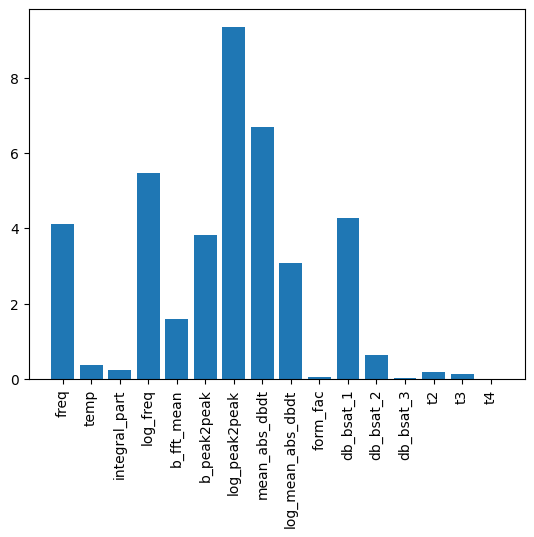

In [33]:
gbm()


### Run objective function single

In [5]:
# objective()
0.045237294288706584

### Run objective function in a hyperparameter optimization loop

In [10]:
import optuna

import sklearn.datasets
import sklearn.ensemble
import sklearn.model_selection
import sklearn.svm


# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).



study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5, n_jobs=3)
#print(study.best_trial)

c:\Users\Oli\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2023-08-17 08:59:20,692] A new study created in memory with name: no-name-b3e84898-41fa-4aec-b3ab-fd8d2940f151
